####  Import useful packages


In [71]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [72]:
DATA_PATH = '../data/' # relatvie path 
# DATA_PATH = '/Users/sisichen/Desktop/DS-unit2-sprint3/data/' # absolute path 

# I.wrangle the dataset

In [73]:
def wrangle(filepath):
    
    df = pd.read_csv(filepath + 'burritos/burritos.csv', parse_dates =['Date'], index_col='Date')
    
    ### drop some columns with large numbers of nan values
    df = df.dropna(axis=1, thresh=30)

    cat_cols = df.select_dtypes(include='object').columns

    ### remove high cardinality columns
    high_card_list = [x for x in cat_cols if df[x].nunique() > 30]
    df = df.drop(columns=high_card_list)

    ### lowercase 'x', and replace the x with 1, nan with 0 
    fillings_cols = df.iloc[:,17:29].columns

    for i in fillings_cols:
        df[i] = df[i].str.lower().replace('x', 1).fillna(0)
        
    return df

In [74]:
df = wrangle(DATA_PATH)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 423 entries, 2016-01-18 to 2019-08-27
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Yelp          87 non-null     float64
 1   Google        87 non-null     float64
 2   Cost          416 non-null    float64
 3   Hunger        420 non-null    float64
 4   Length        284 non-null    float64
 5   Circum        282 non-null    float64
 6   Volume        282 non-null    float64
 7   Tortilla      423 non-null    float64
 8   Temp          403 non-null    float64
 9   Meat          409 non-null    float64
 10  Fillings      420 non-null    float64
 11  Meat:filling  414 non-null    float64
 12  Uniformity    421 non-null    float64
 13  Salsa         398 non-null    float64
 14  Synergy       421 non-null    float64
 15  Wrap          420 non-null    float64
 16  overall       421 non-null    float64
 17  Rec           423 non-null    object 
 18  Unreliable 

In [76]:
df['great'] = df['overall'] > 4.0

In [77]:
X = df.drop(columns=['overall', 'great'])

In [78]:
y = df['great']

# II. Split the dataset


Next, do a **time-based split:**

- Train on reviews from 2016 & earlier. 
- Validate on 2017. 
- Test on 2018 & later.

In [79]:
mask1 = X.index.year <= 2016
mask2 = X.index.year == 2017
mask3 = X.index.year >=2018
X_train, y_train = X.loc[mask1], y.loc[mask1]
X_val, y_val = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[mask3], y.loc[mask3]

# III. set the baseline

In [80]:
print("baseline accuracy is ", y_train.value_counts(normalize=True).max())

baseline accuracy is  0.76


The data is imbalanced, so we will choose roc_auc_score() as the metric!

In [81]:
print("baseline roc auc score is ", roc_auc_score(y_train, [0.4]*len(y_train)))

baseline roc auc score is  0.5


# IV. Build the model

In [82]:
# build a logistic regression model
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                     SimpleImputer(),
                     StandardScaler(),
                     LogisticRegression(random_state=42))

In [83]:
model_lr.fit(X_train, y_train)

/Users/sisichen/Library/Python/3.8/lib/python/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Rec'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [84]:
# build a randomforest model
model_rf = make_pipeline(OneHotEncoder(use_cat_names=True),
                     SimpleImputer(),
                     RandomForestClassifier(n_estimators=20, random_state=42))

In [85]:
model_rf.fit(X_train, y_train)

/Users/sisichen/Library/Python/3.8/lib/python/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Rec'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=20, random_state=42))])

# V. Check Metrics

In [86]:
## Logistic Regression
print("logistic regession model roc auc score for val is", roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,1]))
print("logistic regession model roc auc score for test is", roc_auc_score(y_test, model_lr.predict_proba(X_test)[:,1]))

logistic regession model roc auc score for val is 0.936
logistic regession model roc auc score for test is 0.8484848484848484


In [87]:
# Random Forest
print("random forest model roc auc score for test is", roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,1]))
print("random forest model roc auc score for test is", roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1]))

random forest model roc auc score for test is 0.9603333333333333
random forest model roc auc score for test is 0.9090909090909091


#### Plot the roc auc curve for both models

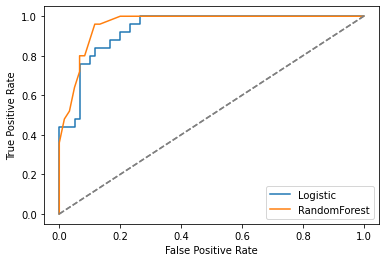

In [88]:
lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='RandomForest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();